In [104]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

In [105]:
#read in csv
alaska = pd.read_csv('../datasets/alaska_single_engine_clean.csv')
pd.set_option('display.max_columns', None)
alaska

,ntsb_no,event_type,mkey,city,n,has_safety_rec,report_type,highest_injury_level,fatal_injury_count,serious_injury_count,minor_injury_count,probable_cause,latitude,longitude,make,model,aircraft_category,airport_id,airport_name,amateur_built,scheduled,purpose_of_flight,far,aircraft_damage,weather_condition,operator,event_year,event_month,event_day,event_time,event_hour,event_season,has_injury,has_aircraft_damage,is_accident,occurred_near_airport,make_model,aircraft_family
0,ANC23LA086,ACC,193153,Trimble River / Skwentna,N2586R,0,DirectorBrief,None Reported,0,0,0,Unknown,61.775160,-152.152630,CESSNA,182K,AIR,No Airport,Trimble River,0,Unknown,PERS,091,Substantial,Unknown,Unknown,2023,9,24,08:30:00,8,Fall,0,1,1,0,CESSNA 182K,CESSNA 182 SKYLANE
1,ANC23LA084,ACC,193128,Bethel,N8192D,0,DirectorBrief,None Reported,0,0,0,Unknown,60.805019,-161.786480,PIPER,PA-18-150,AIR,No Airport,No Airport,0,Unknown,PERS,091,Substantial,Unknown,Unknown,2023,9,20,12:00:00,12,Fall,0,1,1,0,PIPER PA-18-150,PIPER PA-18 SUPER CUB
2,ANC23LA080,ACC,193097,Homer,N7558H,0,DirectorBrief,None Reported,0,0,0,Unknown,59.646929,-151.493230,CESSNA,A185F,AIR,5BL,HOMER-BELUGA LAKE,0,Unknown,BUS,091,Substantial,VMC,Adventure Airways,2023,9,18,13:00:00,13,Fall,0,1,1,1,CESSNA A185F,CESSNA 185 SKYWAGON
3,ANC23LA082,ACC,193105,Beaver Creek,N713C,0,DirectorBrief,None Reported,0,0,0,Unknown,64.267579,-147.687040,HELIO,H-295,AIR,No Airport,No Airport,0,NSCH,BUS,135,Substantial,Unknown,WRIGHT AIR SERVICE INC,2023,9,16,16:50:00,16,Fall,0,1,1,0,HELIO H-295,HELIO COURIER
4,ANC23LA078,ACC,193088,NENANA,N907W,0,DirectorBrief,None Reported,0,0,0,Unknown,64.650753,-149.836390,RHODES STEVEN D,SR3500,AIR,No Airport,No Airport,1,Unknown,PERS,091,Substantial,VMC,Unknown,2023,9,16,15:00:00,15,Fall,0,1,1,0,RHODES STEVEN D SR3500,UNCOMMON FAMILY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5585,ANC82DA014,ACC,69764,ANCHORAGE,N63516,0,DirectorBrief,Minor,0,0,1,Unknown,61.219909,-149.850982,CESSNA,150,AIR,MRI,MERRILL FIELD,0,Unknown,INST,091,Destroyed,VMC,"AERO TECH FLIGHT SERVICE, WC",1982,1,17,10:12:00,10,Winter,1,1,1,1,CESSNA 150,CESSNA 150
5586,ANC82DA015,ACC,71905,NEAR NUIQSUT,N1459T,0,DirectorBrief,None Reported,0,0,0,Unknown,71.280578,-156.779296,DE HAVILLAND,DHC-2-MK3,AIR,No Airport,No Airport,0,NSCH,UNK,135,Substantial,VMC,"SEA AIRMOTIVE, INC.",1982,1,15,17:00:00,17,Winter,0,1,1,0,DE HAVILLAND DHC-2-MK3,DE HAVILLAND DHC-2 BEAVER
5587,ANC82DA013,ACC,72330,QUINHAGAK,N756YN,0,DirectorBrief,Minor,0,0,3,Unknown,59.740913,-161.889205,CESSNA,U206,AIR,No Airport,No Airport,0,NSCH,UNK,135,Substantial,VMC,TRI-CITY AIR SERVICE,1982,1,10,17:55:00,17,Winter,1,1,1,0,CESSNA U206,CESSNA 206 STATIONAIR
5588,ANC82FA012,ACC,69937,BETHEL,N3343S,0,DirectorBrief,Serious,0,2,0,Unknown,60.809120,-161.849258,CESSNA,A185F,AIR,BET,BETHEL,0,NSCH,UNK,135,Substantial,VMC,EXECUTIVE CHARTER SERVICE,1982,1,5,09:39:00,9,Winter,1,1,1,1,CESSNA A185F,CESSNA 185 SKYWAGON


In [106]:
#function to preprocess the 'ProbableCause' column
#this function takes the text from the csv and preprocesses it 
#(changes to lower case, sent tokenzies, word tokenizes,
#removes unnecessary characters, lemmatizes, and puts it in a dataframe)
#help for this function was used from https://git.generalassemb.ly/dsi-911/504-lesson-nlp-i/blob/master/solution-code/solution-code.ipynb and my previous project 3
def preprocessing(dataframe, prob_cause):
    lemmatizer = WordNetLemmatizer()
    tokenizer = RegexpTokenizer('\w+')
    text = dataframe[prob_cause]
    
    lemmatized_data = []
    text = [sent_tokenize(t) for t in text]
    
    for sentences in text:
        sentence = []
        for s in sentences:
            words = tokenizer.tokenize(s)
            words_lemmatized = [lemmatizer.lemmatize(word.lower()) for word in words]
            sentences_lemmatized = ' '.join(words_lemmatized)
            sentence.append(sentences_lemmatized)
        lemmatized_data.append(sentence)
    
    new_data = [' '.join(s) for s in lemmatized_data]
    new_df = pd.DataFrame({'probable_cause': new_data, 'mkey': alaska['mkey'], 'weather': alaska['weather_condition'], 'season': alaska['event_season'], 'make': alaska['make'], 'model': alaska['model'], 'damage': alaska['aircraft_damage'], 'latitude': alaska['latitude'], 'longitude': alaska['longitude'], 'highest_injury': alaska['highest_injury_level']})
    
    return new_df

In [107]:
new_alaska = preprocessing(alaska, 'probable_cause')
new_alaska.head()

,probable_cause,mkey,weather,season,make,model,damage,latitude,longitude,highest_injury
0,unknown,193153,Unknown,Fall,CESSNA,182K,Substantial,61.775160,-152.15263,None Reported
1,unknown,193128,Unknown,Fall,PIPER,PA-18-150,Substantial,60.805019,-161.78648,None Reported
2,unknown,193097,VMC,Fall,CESSNA,A185F,Substantial,59.646929,-151.49323,None Reported
3,unknown,193105,Unknown,Fall,HELIO,H-295,Substantial,64.267579,-147.68704,None Reported
4,unknown,193088,VMC,Fall,RHODES STEVEN D,SR3500,Substantial,64.650753,-149.83639,None Reported


# Model for Probable Cause of Airplane

In [108]:
#X = new_alaska.drop('highest_injury', axis=1)
X = new_alaska['probable_cause']
y = new_alaska['highest_injury']

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# CountVectorizer

In [111]:
cvec = CountVectorizer(stop_words='english')

In [112]:
cvec.fit(X_train)

CountVectorizer(stop_words='english')

In [113]:
X_train = cvec.transform(X_train)

In [114]:
X_test = cvec.transform(X_test)

In [115]:
X_train_df = pd.DataFrame(X_train.todense(), columns=cvec.get_feature_names_out())

In [142]:
#train test split for n-grams
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X, y, random_state=42)

# Count Vectorizer for N-grams

In [143]:
cvec_n = CountVectorizer(stop_words='english', ngram_range=(4,4))

cvec_n.fit(X_train_n)

X_train_n = cvec_n.transform(X_train_n)
X_test_n = cvec_n.transform(X_test_n)

In [144]:
X_train_df_n = pd.DataFrame(X_train_n.todense(), 
                          columns=cvec_n.get_feature_names_out())

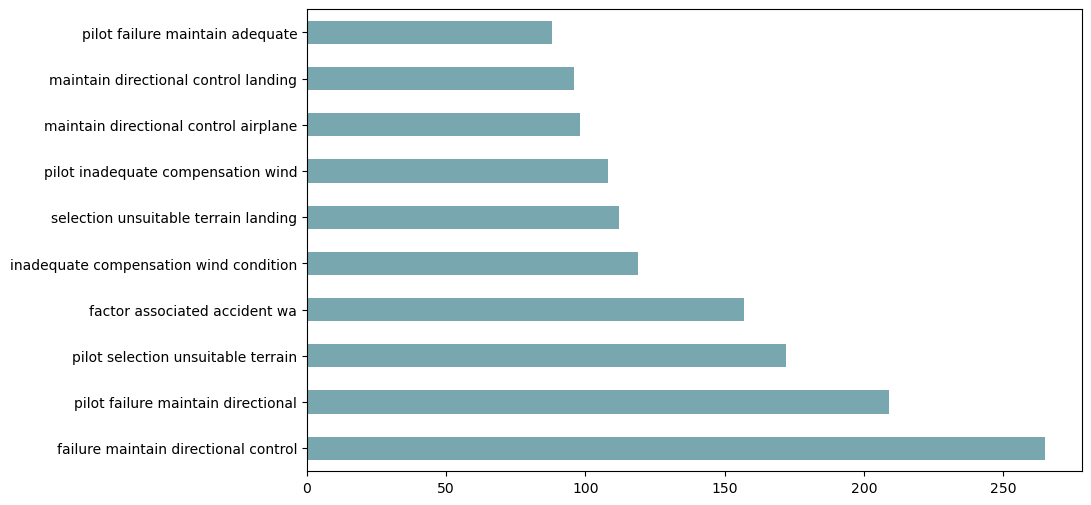

In [150]:
#help for this was used from https://stackoverflow.com/questions/37427362/plt-show-shows-full-graph-but-savefig-is-cropping-the-image
X_train_df_n.sum().sort_values(ascending = False).head(10).plot(kind = 'barh', color='#78A7AF');
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.savefig('probable_cause.png', dpi=300, bbox_inches='tight')
plt.show()

# Logistic Regression Model

In [117]:
lr = LogisticRegression(penalty = 'l1', solver='liblinear')

lr.fit(X_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [118]:
preds = lr.predict(X_test)

In [119]:
lr.score(X_train, y_train)

0.7788645038167938

In [120]:
lr.score(X_test, y_test)

0.748211731044349

# Random Forest Classifier

In [121]:
rf = RandomForestClassifier(oob_score=True, max_features='sqrt')
rf.fit(X_train, y_train)

RandomForestClassifier(oob_score=True)

In [122]:
rf.score(X_test, y_test)

0.7575107296137339

In [123]:
rf.oob_score_

0.7330629770992366

In [124]:
pred = rf.predict(X_test)

In [146]:
pd.DataFrame({
    'features': cvec.get_feature_names_out(),
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False).head(10)

,features,importance
1175,landing,0.016870
874,flight,0.015610
1531,pilot,0.014021
1989,stall,0.013133
2119,terrain,0.012580
1123,instrument,0.011043
101,airspeed,0.010541
840,failure,0.010201
1753,resulted,0.010013
441,condition,0.009662


## Metrics

In [126]:
lr_baseline = accuracy_score(y_test, preds)
lr_baseline

0.748211731044349

In [127]:
rf_baseline = accuracy_score(y_test, pred)
rf_baseline

0.7575107296137339

# Model for Make of Airplane

In [128]:
X2 = new_alaska['make']
y2 = new_alaska['highest_injury']

In [129]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=42)

# Count Vectorizer

In [130]:
cvec2 = CountVectorizer(stop_words='english')

In [131]:
cvec2.fit(X_train2)

CountVectorizer(stop_words='english')

In [132]:
X_train2 = cvec2.transform(X_train2)

In [133]:
X_test2 = cvec2.transform(X_test2)

In [134]:
X_train_df2 = pd.DataFrame(X_train2.todense(), columns=cvec2.get_feature_names_out())

# Random Forest Classifier

In [135]:
rf2 = RandomForestClassifier(oob_score=True, max_features='sqrt')
rf2.fit(X_train2, y_train2)

RandomForestClassifier(oob_score=True)

In [136]:
rf2.score(X_test2, y_test2)

0.7281831187410587

In [137]:
rf2.oob_score_

0.708969465648855

In [138]:
pred2 = rf2.predict(X_test2)

In [147]:
pd.DataFrame({
    'features': cvec2.get_feature_names_out(),
    'importance': rf2.feature_importances_
}).sort_values('importance', ascending=False).head(10)

,features,importance
27,bell,0.025789
26,beech,0.023573
90,eurocopter,0.022799
242,waspair,0.021527
113,havilland,0.018677
117,helicopters,0.014903
127,hughes,0.013350
225,taylorcraft,0.012381
185,piper,0.011554
55,colburn,0.010332


## Metrics

In [140]:
rf_baseline2 = accuracy_score(y_test2, pred2)
rf_baseline2

0.7281831187410587